In [4]:
import matplotlib.pyplot as plt
import time

In [5]:
from common_functions import *

In [6]:
from encodec import EncodecModel
from encodec.utils import convert_audio
import torchaudio
import torch
import resampy

In [11]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=None,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16256,
    subset='both')

model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(24) 

C = []
Cv = []
yC = []
yCv = []
for xi,yi in train_ds:
    c = encodec(xi,model)
    C.append(np.expand_dims(c,0))
    yC.append(yi)
for xi,yi in val_ds:
    c = encodec(xi,model)
    Cv.append(np.expand_dims(c,0))
    yCv.append(yi)
C = np.vstack(C)
yC = np.vstack(yC)
Cv = np.vstack(Cv)
yCv = np.vstack(yCv)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [12]:
np.save('encodec_transformed_data/C',C)
np.save('encodec_transformed_data/yC',yC)
np.save('encodec_transformed_data/Cv',Cv)
np.save('encodec_transformed_data/yCv',yCv)

In [9]:
def encodec(x, model):
    wav = torch.tensor(np.reshape(x,-1)).unsqueeze(0).unsqueeze(0)
    wav = convert_audio(wav, 16256, model.sample_rate, model.channels)
    with torch.no_grad():
        encoded_frames = model.encode(wav)
    return encoded_frames

def load_mini_speech_commands_encodec():
    DATASET_PATH = 'data/mini_speech_commands'

    data_dir = pathlib.Path(DATASET_PATH)
    if not data_dir.exists():
      tf.keras.utils.get_file(
          'mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True,
          cache_dir='.', cache_subdir='data')

    train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=data_dir,
        batch_size=None,
        validation_split=0.2,
        seed=0,
        output_sequence_length=16256,
        subset='both')
    
    model = EncodecModel.encodec_model_24khz()
    model.set_target_bandwidth(24) 
    
    C = []
    Cv = []
    yC = []
    yCv = []
    for xi,yi in train_ds:
        c = encodec(xi,model)
        C.append(np.expand_dims(c,0))
        yC.append(yi)
    for xi,yi in val_ds:
        c = encodec(xi,model)
        Cv.append(np.expand_dims(c,0))
        yCv.append(yi)
    C = np.vstack(C)
    yC = np.vstack(yC)
    Cv = np.vstack(Cv)
    yCv = np.vstack(yCv)
    
    return C, yC, Cv, yCv

In [10]:
C, yC, Cv, yCv = load_mini_speech_commands_encodec()
np.save('encodec_transformed_data/C',C)
np.save('encodec_transformed_data/yC',yC)
np.save('encodec_transformed_data/Cv',Cv)
np.save('encodec_transformed_data/yCv',yCv)

# C = np.load('encodec_transformed_data/C.npy')
# Cv = np.load('encodec_transformed_data/Cv.npy')
# y = np.load('encodec_transformed_data/yC.npy')
# yv = np.load('encodec_transformed_data/yCv.npy')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


2023-02-26 09:17:57.655395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 09:17:57.660311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 09:17:57.660544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 09:17:57.661074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [6]:
model = models.Sequential([
    layers.Input(shape=(128,128,1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                        

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [8]:
train_acc = [];
test_acc = [];
elapsed_time = [];

2023-02-26 09:02:50.806714: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2023-02-26 09:02:51.062782: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.
2023-02-26 09:02:53.089315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-02-26 09:02:53.995567: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-26 09:02:54.206259: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2f033d1e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-26 09:02:54.206288: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-02-26 09:02:54.230185: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR cra

100/100 [==============================] - 7s 20ms/step - loss: 1.6853 - accuracy: 0.4280


2023-02-26 09:02:58.240765: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 104857600 exceeds 10% of free system memory.
2023-02-26 09:02:58.317268: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 104857600 exceeds 10% of free system memory.


50/50 [==============================] - 0s 5ms/step - loss: 1.3351 - accuracy: 0.5788


2023-02-26 09:02:58.923204: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 419430400 exceeds 10% of free system memory.


50/50 [==============================] - 0s 4ms/step - loss: 1.6143 - accuracy: 0.7531


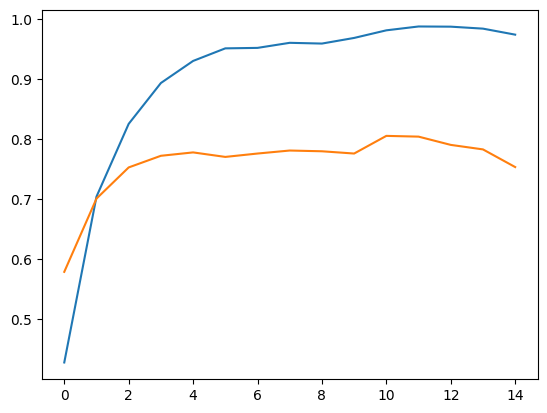

In [9]:
for i_iter in range(15):
    t = time.process_time()
    train_history = model.fit(x=X, y=y, epochs=1, batch_size=64);
    elapsed_time.append(time.process_time()-t)
    _, test_acc_i = model.evaluate(x=Xv, y=yv)
    train_acc.append(train_history.history['accuracy'][0])
    test_acc.append(test_acc_i)
plt.plot(np.vstack(train_acc))
plt.plot(np.vstack(test_acc))

In [10]:
print(np.median(elapsed_time), "seconds/iteration")
print(np.median(test_acc[-5:]), "test accuracy")

2.887506840000242 seconds/iteration
0.7900000214576721 test accuracy
